In [4]:
import os
import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
print('test started')
base_path = "/Data/hamza.azzouzi/bg_challenge"
attacked_categories = [
    "mixed_next", "mixed_rand", "mixed_same", "no_fg", 
    "only_bg_b", "only_bg_t", "only_fg", 'original'
]
CLASS_TO_IDX = {
    'bird': 0, 'carnivore': 1, 'dog': 2, 'fish': 3,
    'insect': 4, 'instrument': 5, 'primate': 6,
    'reptile': 7, 'vehicle': 8
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AttackedDataset(Dataset):
    def __init__(self, root, class_to_idx, transform=None):
        self.samples = []
        self.transform = transform

        for class_folder in os.listdir(root):
            class_path = os.path.join(root, class_folder)
            if not os.path.isdir(class_path):
                continue  

            # Extract the class name from the folder name
            class_name = class_folder.split("_", 1)[1].lower()
            if class_name == "wheeled vehicle":
                class_name = "vehicle"
            if class_name == "musical instrument":
                class_name = "instrument"

            # If the class isn't in our index, skip
            if class_name not in class_to_idx:
                print(f"⚠️  Ignored: {class_folder} (not in CLASS_TO_IDX)")
                continue  

            label = class_to_idx[class_name]  

            valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".JPEG"]
            for ext in valid_extensions:
                for img_path in glob.glob(os.path.join(class_path, f"*{ext}")):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")  
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



test started


# Training the whole Resnet


## 40 Epochs

In [7]:
# -- Initialize Model --
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 9)

# Load local weights from 'resnet50-19c8e357.pth'
# (Remove "weights_only=False" unless you specifically need it for your PyTorch version)
state_dict = torch.load("resnet50_epoch_40.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)

# Move to GPU if available
model.to(device)



# -- Tracking Accuracy --
category_accuracies = {}
total_correct = 0
total_samples = 0

for cat in attacked_categories:
    cat_val_path = os.path.join(base_path, cat, "val")

    if os.path.isdir(cat_val_path):
        dataset = AttackedDataset(root=cat_val_path,
                                  class_to_idx=CLASS_TO_IDX,
                                  transform=transform)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)  

                correct += (preds == labels).sum().item()
                total   += labels.size(0)

        accuracy = correct / total if total > 0 else 0.0
        category_accuracies[cat] = accuracy

        total_correct  += correct
        total_samples  += total

        print(f"✅ Accuracy on {cat}: {accuracy:.4f}")
    else:
        print(f"⚠️ Directory {cat_val_path} not found. Skipping.")

global_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

print("\n📊 **Final Results:**")
for cat, acc in category_accuracies.items():
    print(f" - {cat}: {acc:.4f}")

print(f"\n🎯 **Global accuracy across all attacked categories: {global_accuracy:.4f}**")


/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Accuracy on mixed_next: 0.6565
✅ Accuracy on mixed_rand: 0.6635
✅ Accuracy on mixed_same: 0.7005
✅ Accuracy on no_fg: 0.3084
✅ Accuracy on only_bg_b: 0.1207
✅ Accuracy on only_bg_t: 0.2089
✅ Accuracy on only_fg: 0.7743

📊 **Final Results:**
 - mixed_next: 0.6565
 - mixed_rand: 0.6635
 - mixed_same: 0.7005
 - no_fg: 0.3084
 - only_bg_b: 0.1207
 - only_bg_t: 0.2089
 - only_fg: 0.7743

🎯 **Global accuracy across all attacked categories: 0.4904**


## 60 epochs

In [8]:
# -- Initialize Model --
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)


# Load local weights from 'resnet50-19c8e357.pth'
# (Remove "weights_only=False" unless you specifically need it for your PyTorch version)
state_dict = torch.load("resnet50_epoch_60.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)

# Move to GPU if available
model.to(device)



# -- Tracking Accuracy --
category_accuracies = {}
total_correct = 0
total_samples = 0

for cat in attacked_categories:
    cat_val_path = os.path.join(base_path, cat, "val")

    if os.path.isdir(cat_val_path):
        dataset = AttackedDataset(root=cat_val_path,
                                  class_to_idx=CLASS_TO_IDX,
                                  transform=transform)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)  

                correct += (preds == labels).sum().item()
                total   += labels.size(0)

        accuracy = correct / total if total > 0 else 0.0
        category_accuracies[cat] = accuracy

        total_correct  += correct
        total_samples  += total

        print(f"✅ Accuracy on {cat}: {accuracy:.4f}")
    else:
        print(f"⚠️ Directory {cat_val_path} not found. Skipping.")

global_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

print("\n📊 **Final Results:**")
for cat, acc in category_accuracies.items():
    print(f" - {cat}: {acc:.4f}")

print(f"\n🎯 **Global accuracy across all attacked categories: {global_accuracy:.4f}**")


✅ Accuracy on mixed_next: 0.6837
✅ Accuracy on mixed_rand: 0.6896
✅ Accuracy on mixed_same: 0.7136
✅ Accuracy on no_fg: 0.3091
✅ Accuracy on only_bg_b: 0.1165
✅ Accuracy on only_bg_t: 0.1869
✅ Accuracy on only_fg: 0.7914

📊 **Final Results:**
 - mixed_next: 0.6837
 - mixed_rand: 0.6896
 - mixed_same: 0.7136
 - no_fg: 0.3091
 - only_bg_b: 0.1165
 - only_bg_t: 0.1869
 - only_fg: 0.7914

🎯 **Global accuracy across all attacked categories: 0.4987**


## 80 epochs

In [9]:
# -- Initialize Model --
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)


# Load local weights from 'resnet50-19c8e357.pth'
# (Remove "weights_only=False" unless you specifically need it for your PyTorch version)
state_dict = torch.load("resnet50_epoch_80.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)

# Move to GPU if available
model.to(device)



# -- Tracking Accuracy --
category_accuracies = {}
total_correct = 0
total_samples = 0

for cat in attacked_categories:
    cat_val_path = os.path.join(base_path, cat, "val")

    if os.path.isdir(cat_val_path):
        dataset = AttackedDataset(root=cat_val_path,
                                  class_to_idx=CLASS_TO_IDX,
                                  transform=transform)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)  

                correct += (preds == labels).sum().item()
                total   += labels.size(0)

        accuracy = correct / total if total > 0 else 0.0
        category_accuracies[cat] = accuracy

        total_correct  += correct
        total_samples  += total

        print(f"✅ Accuracy on {cat}: {accuracy:.4f}")
    else:
        print(f"⚠️ Directory {cat_val_path} not found. Skipping.")

global_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

print("\n📊 **Final Results:**")
for cat, acc in category_accuracies.items():
    print(f" - {cat}: {acc:.4f}")

print(f"\n🎯 **Global accuracy across all attacked categories: {global_accuracy:.4f}**")


✅ Accuracy on mixed_next: 0.6489
✅ Accuracy on mixed_rand: 0.6578
✅ Accuracy on mixed_same: 0.6926
✅ Accuracy on no_fg: 0.3331
✅ Accuracy on only_bg_b: 0.1225
✅ Accuracy on only_bg_t: 0.2133
✅ Accuracy on only_fg: 0.7677

📊 **Final Results:**
 - mixed_next: 0.6489
 - mixed_rand: 0.6578
 - mixed_same: 0.6926
 - no_fg: 0.3331
 - only_bg_b: 0.1225
 - only_bg_t: 0.2133
 - only_fg: 0.7677

🎯 **Global accuracy across all attacked categories: 0.4908**


## 100 epochs

In [14]:
# -- Initialize Model --
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)


# Load local weights from 'resnet50-19c8e357.pth'
# (Remove "weights_only=False" unless you specifically need it for your PyTorch version)
state_dict = torch.load("resnet50_epoch_100.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)

# Move to GPU if available
model.to(device)



# -- Tracking Accuracy --
category_accuracies = {}
total_correct = 0
total_samples = 0

for cat in attacked_categories:
    cat_val_path = os.path.join(base_path, cat, "val")

    if os.path.isdir(cat_val_path):
        dataset = AttackedDataset(root=cat_val_path,
                                  class_to_idx=CLASS_TO_IDX,
                                  transform=transform)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)  

                correct += (preds == labels).sum().item()
                total   += labels.size(0)

        accuracy = correct / total if total > 0 else 0.0
        category_accuracies[cat] = accuracy

        total_correct  += correct
        total_samples  += total

        print(f"✅ Accuracy on {cat}: {accuracy:.4f}")
    else:
        print(f"⚠️ Directory {cat_val_path} not found. Skipping.")

global_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

print("\n📊 **Final Results:**")
for cat, acc in category_accuracies.items():
    print(f" - {cat}: {acc:.4f}")

print(f"\n🎯 **Global accuracy across all attacked categories: {global_accuracy:.4f}**")


✅ Accuracy on mixed_next: 0.6652
✅ Accuracy on mixed_rand: 0.6770
✅ Accuracy on mixed_same: 0.7069
✅ Accuracy on no_fg: 0.3215
✅ Accuracy on only_bg_b: 0.1173
✅ Accuracy on only_bg_t: 0.2054
✅ Accuracy on only_fg: 0.7684
✅ Accuracy on original: 0.8054

📊 **Final Results:**
 - mixed_next: 0.6652
 - mixed_rand: 0.6770
 - mixed_same: 0.7069
 - no_fg: 0.3215
 - only_bg_b: 0.1173
 - only_bg_t: 0.2054
 - only_fg: 0.7684
 - original: 0.8054

🎯 **Global accuracy across all attacked categories: 0.5334**


# MLP


## 10 epochs

In [ ]:
# -- Initialize Model --
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
mlp_head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 9)
)
model.fc = mlp_head

# Load local weights from 'resnet50-19c8e357.pth'
# (Remove "weights_only=False" unless you specifically need it for your PyTorch version)
state_dict = torch.load("models_mlp/resnet50_epoch_10.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)

# Move to GPU if available
model.to(device)



# -- Tracking Accuracy --
category_accuracies = {}
total_correct = 0
total_samples = 0

for cat in attacked_categories:
    cat_val_path = os.path.join(base_path, cat, "val")

    if os.path.isdir(cat_val_path):
        dataset = AttackedDataset(root=cat_val_path,
                                  class_to_idx=CLASS_TO_IDX,
                                  transform=transform)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)  

                correct += (preds == labels).sum().item()
                total   += labels.size(0)

        accuracy = correct / total if total > 0 else 0.0
        category_accuracies[cat] = accuracy

        total_correct  += correct
        total_samples  += total

        print(f"✅ Accuracy on {cat}: {accuracy:.4f}")
    else:
        print(f"⚠️ Directory {cat_val_path} not found. Skipping.")

global_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

print("\n📊 **Final Results:**")
for cat, acc in category_accuracies.items():
    print(f" - {cat}: {acc:.4f}")

print(f"\n🎯 **Global accuracy across all attacked categories: {global_accuracy:.4f}**")


## 20 epochs

In [13]:
# -- Initialize Model --
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
mlp_head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 9)
)
model.fc = mlp_head

# Load local weights from 'resnet50-19c8e357.pth'
# (Remove "weights_only=False" unless you specifically need it for your PyTorch version)
state_dict = torch.load("models_mlp/resnet50_epoch_20.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)

# Move to GPU if available
model.to(device)



# -- Tracking Accuracy --
category_accuracies = {}
total_correct = 0
total_samples = 0

for cat in attacked_categories:
    cat_val_path = os.path.join(base_path, cat, "val")

    if os.path.isdir(cat_val_path):
        dataset = AttackedDataset(root=cat_val_path,
                                  class_to_idx=CLASS_TO_IDX,
                                  transform=transform)
        data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, preds = torch.max(outputs, 1)  

                correct += (preds == labels).sum().item()
                total   += labels.size(0)

        accuracy = correct / total if total > 0 else 0.0
        category_accuracies[cat] = accuracy

        total_correct  += correct
        total_samples  += total

        print(f"✅ Accuracy on {cat}: {accuracy:.4f}")
    else:
        print(f"⚠️ Directory {cat_val_path} not found. Skipping.")

global_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

print("\n📊 **Final Results:**")
for cat, acc in category_accuracies.items():
    print(f" - {cat}: {acc:.4f}")

print(f"\n🎯 **Global accuracy across all attacked categories: {global_accuracy:.4f}**")


/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Accuracy on mixed_next: 0.8215
✅ Accuracy on mixed_rand: 0.8259
✅ Accuracy on mixed_same: 0.8607
✅ Accuracy on no_fg: 0.5131
✅ Accuracy on only_bg_b: 0.1593
✅ Accuracy on only_bg_t: 0.2306
✅ Accuracy on only_fg: 0.8775
✅ Accuracy on original: 0.9109

📊 **Final Results:**
 - mixed_next: 0.8215
 - mixed_rand: 0.8259
 - mixed_same: 0.8607
 - no_fg: 0.5131
 - only_bg_b: 0.1593
 - only_bg_t: 0.2306
 - only_fg: 0.8775
 - original: 0.9109

🎯 **Global accuracy across all attacked categories: 0.6499**


## 30 epochs

In [ ]:
import os
import glob
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms

# -----------------------------------------------------------------------------
# -- Initialize Model --
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
mlp_head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 9)
)
model.fc = mlp_head

# Load local weights from 'resnet50-19c8e357.pth'
# (Remove "weights_only=False" unless you specifically need it for your PyTorch version)
state_dict = torch.load("models_mlp/resnet50_epoch_20.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)

# Move to GPU if available
model.to(device)
# -----------------------------------------------------------------------------
# 2. Define preprocessing transformations
# -----------------------------------------------------------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard for ImageNet
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------------------------------------------------------
# 3. Helper function to generate saliency maps
# -----------------------------------------------------------------------------
def generate_saliency(model, input_tensor):
    """
    Generate a saliency map for a single input image tensor.
    """
    input_tensor.requires_grad_()  # Enable gradients for the input
    output = model(input_tensor)
    
    # Choose the top predicted class
    target_class = output.argmax(dim=1).item()
    
    model.zero_grad()
    score = output[0, target_class]
    score.backward()
    
    # Get absolute gradients
    saliency = input_tensor.grad.data.abs().squeeze().numpy()
    if saliency.ndim == 3:  # if RGB image, take the max across channels
        saliency = np.max(saliency, axis=0)
    
    # Normalize the saliency map for visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency

# -----------------------------------------------------------------------------
# 4. Iterate over each top-level folder and process one image per sub-subfolder
# -----------------------------------------------------------------------------
root_folder = '/Data/hamza.azzouzi/bg_challenge'

# Loop over each category folder (e.g. "fg_mask", "mixed_next", etc.)
for category in os.listdir(root_folder):
    category_path = os.path.join(root_folder, category)
    if not os.path.isdir(category_path):
        continue

    # Expecting a 'val' folder inside each category
    val_folder = os.path.join(category_path, 'val')
    if not os.path.isdir(val_folder):
        continue

    # Loop over each subfolder inside 'val' (e.g. "00_dog", "01_bird", etc.)
    for subcat in os.listdir(val_folder):
        subcat_path = os.path.join(val_folder, subcat)
        if not os.path.isdir(subcat_path):
            continue

        # Look for the first .npy file in this subfolder
        npy_files = glob.glob(os.path.join(subcat_path, '*.npy'))
        if not npy_files:
            continue
        first_npy = npy_files[0]

        # Load the .npy file (assuming it stores an image array)
        img_array = np.load(first_npy)
        # If the array is in shape (3, H, W), convert it to (H, W, 3)
        if img_array.ndim == 3 and img_array.shape[0] == 3:
            img_array = np.transpose(img_array, (1, 2, 0))
        # Convert to uint8 if needed, handling boolean arrays
        if img_array.dtype != np.uint8:
            if img_array.dtype == np.bool_:
                img_array = img_array.astype(np.float32)
            img_array = (255 * (img_array - img_array.min()) / (img_array.ptp() + 1e-8)).astype(np.uint8)
        img_pil = Image.fromarray(img_array)
        
        # Ensure the image is in RGB mode for preprocessing
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')

        # Preprocess image for the model
        img_tensor = preprocess(img_pil).unsqueeze(0)  # shape: (1, 3, 224, 224)

        # Generate saliency map
        saliency_map = generate_saliency(model, img_tensor.clone())

        # Display original image and saliency map side by side
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img_pil)
        plt.title(f"Original - {category}/{subcat}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.title("Saliency Map")
        plt.axis('off')

        plt.show()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


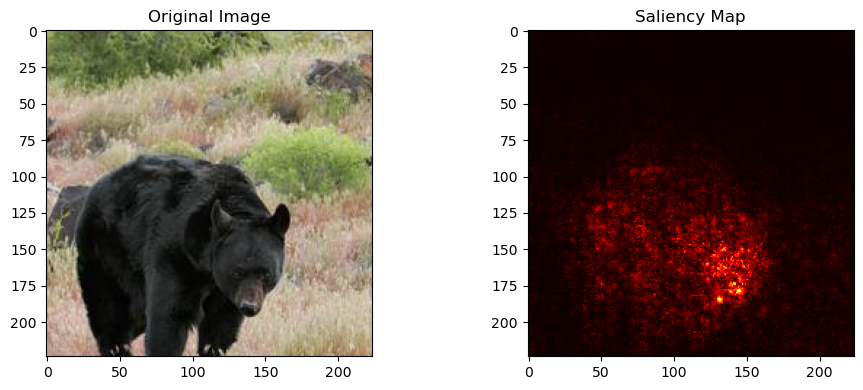

Random image index: 2376
True label index:   1
Predicted class:    1


In [16]:
import os
import random
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# =========== MODEL & DATA PREP ==============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mapping from your original code
CLASS_TO_IDX = {
    'bird': 0, 'carnivore': 1, 'dog': 2, 'fish': 3,
    'insect': 4, 'instrument': 5, 'primate': 6,
    'reptile': 7, 'vehicle': 8
}

# Simple image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

# Custom dataset (same as your AttackedDataset, but shorter for example)
class AttackedDataset(Dataset):
    def __init__(self, root, class_to_idx, transform=None):
        self.samples = []
        self.transform = transform
        valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".JPEG"]

        for class_folder in os.listdir(root):
            class_path = os.path.join(root, class_folder)
            if not os.path.isdir(class_path):
                continue

            # Adjust folder name to match keys in CLASS_TO_IDX
            class_name = class_folder.split("_", 1)[1].lower()
            if class_name == "wheeled vehicle":
                class_name = "vehicle"
            if class_name == "musical instrument":
                class_name = "instrument"

            if class_name not in class_to_idx:
                continue
            
            label = class_to_idx[class_name]

            for ext in valid_extensions:
                for img_path in glob.glob(os.path.join(class_path, f"*{ext}")):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# ============= LOAD THE MODEL ================
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features

mlp_head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 9)
)
model.fc = mlp_head

state_dict = torch.load("models_mlp/resnet50_epoch_20.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

# =========== CHOOSE A VALIDATION FOLDER ===============
# For example, pick "original/val" or any attacked category "mixed_rand/val", etc.
base_path = "/Data/hamza.azzouzi/bg_challenge"
val_path = os.path.join(base_path, "original", "val")  # or pick another subfolder

# =========== BUILD DATASET & CHOOSE RANDOM IMAGE ======
dataset = AttackedDataset(root=val_path, class_to_idx=CLASS_TO_IDX, transform=transform)

# Pick a random index
random_idx = random.randint(0, len(dataset) - 1)
image_tensor, label = dataset[random_idx]

# Unsqueeze to have batch dimension of 1
image_tensor = image_tensor.unsqueeze(0).to(device)
image_tensor.requires_grad_()  # Make sure we can get grads w.r.t. input

# =========== FORWARD PASS & FIND PREDICTED CLASS ======
output = model(image_tensor)
pred_class = output.argmax(dim=1)  # predicted class index

# =========== BACKWARD PASS (Grad for Saliency) ========
# We backprop on the predicted class logit
score = output[0, pred_class]
model.zero_grad()         # Zero any existing gradients
score.backward()          # Backprop to get gradient w.r.t. input

# image_tensor.grad now holds the gradient for each pixel
saliency = image_tensor.grad.data.abs().squeeze(0)

# Often for visualization, we take the maximum across channels
saliency, _ = torch.max(saliency, dim=0)

# Convert to CPU for plotting
saliency = saliency.cpu()

# =========== VISUALIZATION ============================
# Original image (unnormalize just for display, if desired)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Copy of the original image before gradient
original_img = image_tensor.clone().detach().squeeze(0).cpu()
original_img = denormalize(original_img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
original_img = torch.clamp(original_img, 0, 1)  # clamp to [0,1]

# Plot the original image and its saliency map
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img.permute(1, 2, 0).numpy())

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency.numpy(), cmap='hot')  # 'hot' is a common saliency colormap

plt.tight_layout()
plt.show()

print(f"Random image index: {random_idx}")
print(f"True label index:   {label}")
print(f"Predicted class:    {pred_class.item()}")


/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2022/hamza.azzouzi/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


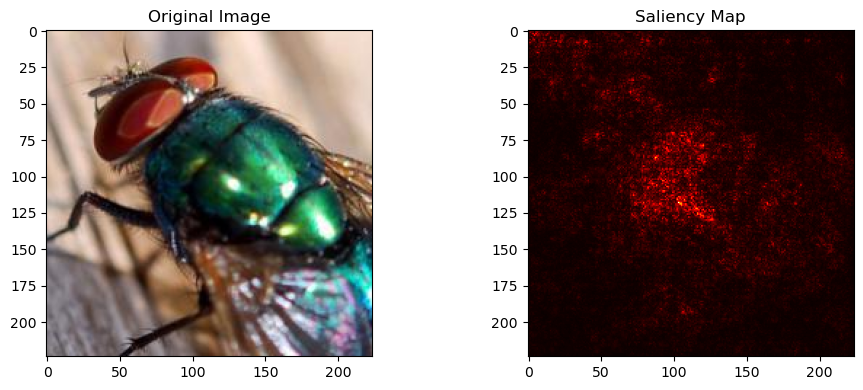

Random image index: 1554
True label index:   4
Predicted class:    4


In [1]:
import os
import random
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# =========== MODEL & DATA PREP ==============
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mapping from your original code
CLASS_TO_IDX = {
    'bird': 0, 'carnivore': 1, 'dog': 2, 'fish': 3,
    'insect': 4, 'instrument': 5, 'primate': 6,
    'reptile': 7, 'vehicle': 8
}

# Simple image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

# Custom dataset (same as your AttackedDataset, but shorter for example)
class AttackedDataset(Dataset):
    def __init__(self, root, class_to_idx, transform=None):
        self.samples = []
        self.transform = transform
        valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".JPEG"]

        for class_folder in os.listdir(root):
            class_path = os.path.join(root, class_folder)
            if not os.path.isdir(class_path):
                continue

            # Adjust folder name to match keys in CLASS_TO_IDX
            class_name = class_folder.split("_", 1)[1].lower()
            if class_name == "wheeled vehicle":
                class_name = "vehicle"
            if class_name == "musical instrument":
                class_name = "instrument"

            if class_name not in class_to_idx:
                continue
            
            label = class_to_idx[class_name]

            for ext in valid_extensions:
                for img_path in glob.glob(os.path.join(class_path, f"*{ext}")):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# ============= LOAD THE MODEL ================
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features


model.fc = nn.Linear(num_ftrs,9)

state_dict = torch.load("resnet50_trained.pth", map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

# =========== CHOOSE A VALIDATION FOLDER ===============
# For example, pick "original/val" or any attacked category "mixed_rand/val", etc.
base_path = "/Data/hamza.azzouzi/bg_challenge"
val_path = os.path.join(base_path, "original", "val")  # or pick another subfolder

# =========== BUILD DATASET & CHOOSE RANDOM IMAGE ======
dataset = AttackedDataset(root=val_path, class_to_idx=CLASS_TO_IDX, transform=transform)

# Pick a random index
random_idx = random.randint(0, len(dataset) - 1)
image_tensor, label = dataset[random_idx]

# Unsqueeze to have batch dimension of 1
image_tensor = image_tensor.unsqueeze(0).to(device)
image_tensor.requires_grad_()  # Make sure we can get grads w.r.t. input

# =========== FORWARD PASS & FIND PREDICTED CLASS ======
output = model(image_tensor)
pred_class = output.argmax(dim=1)  # predicted class index

# =========== BACKWARD PASS (Grad for Saliency) ========
# We backprop on the predicted class logit
score = output[0, pred_class]
model.zero_grad()         # Zero any existing gradients
score.backward()          # Backprop to get gradient w.r.t. input

# image_tensor.grad now holds the gradient for each pixel
saliency = image_tensor.grad.data.abs().squeeze(0)

# Often for visualization, we take the maximum across channels
saliency, _ = torch.max(saliency, dim=0)

# Convert to CPU for plotting
saliency = saliency.cpu()

# =========== VISUALIZATION ============================
# Original image (unnormalize just for display, if desired)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Copy of the original image before gradient
original_img = image_tensor.clone().detach().squeeze(0).cpu()
original_img = denormalize(original_img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
original_img = torch.clamp(original_img, 0, 1)  # clamp to [0,1]

# Plot the original image and its saliency map
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img.permute(1, 2, 0).numpy())

plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency.numpy(), cmap='hot')  # 'hot' is a common saliency colormap

plt.tight_layout()
plt.show()

print(f"Random image index: {random_idx}")
print(f"True label index:   {label}")
print(f"Predicted class:    {pred_class.item()}")


Dataset size: 4050 samples


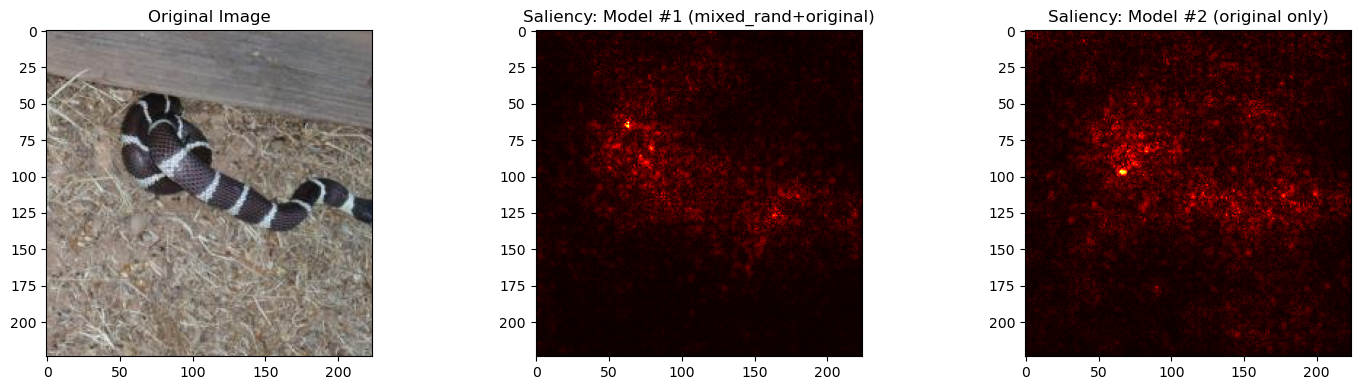

Random image index in dataset: 1335
True label index:              7 (reptile)
Model #1 predicted class idx:  7 (reptile)
Model #2 predicted class idx:  7 (reptile)


In [3]:
import os
import random
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# --------------------------------------------------
# 1) DEVICE & CLASS MAPPINGS
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mapping from your original code
CLASS_TO_IDX = {
    'bird': 0, 'carnivore': 1, 'dog': 2, 'fish': 3,
    'insect': 4, 'instrument': 5, 'primate': 6,
    'reptile': 7, 'vehicle': 8
}

# (Optional) If you want to map indices back to class names:
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}


# --------------------------------------------------
# 2) DATASET DEFINITION
#    We only pick from 'original/val' or 'mixed_rand/val', etc.
#    (Adjust the base path as needed.)
# --------------------------------------------------
class AttackedDataset(Dataset):
    def __init__(self, root, class_to_idx, transform=None):
        self.samples = []
        self.transform = transform
        valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".JPEG"]

        for class_folder in os.listdir(root):
            class_path = os.path.join(root, class_folder)
            if not os.path.isdir(class_path):
                continue

            # Convert folder name into a recognized class key
            # Example folder might be "n01614925_wheeled vehicle"
            # so we split on the first underscore.
            parts = class_folder.split("_", 1)
            if len(parts) < 2:
                continue

            class_name = parts[1].lower()  # e.g. "wheeled vehicle"
            if class_name == "wheeled vehicle":
                class_name = "vehicle"
            if class_name == "musical instrument":
                class_name = "instrument"

            if class_name not in class_to_idx:
                continue

            label = class_to_idx[class_name]

            # Gather images
            for ext in valid_extensions:
                for img_path in glob.glob(os.path.join(class_path, f"*{ext}")):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# --------------------------------------------------
# 3) IMAGE TRANSFORMS & DATA LOADING
# --------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

base_path = "/Data/hamza.azzouzi/bg_challenge"
val_path = os.path.join(base_path, "original", "val")  # or "mixed_rand/val", etc.

dataset = AttackedDataset(root=val_path, class_to_idx=CLASS_TO_IDX, transform=transform)

print(f"Dataset size: {len(dataset)} samples")
if len(dataset) == 0:
    raise ValueError("No samples found. Check your 'val_path' or folder structure.")

# Pick one random image
random_idx = random.randint(0, len(dataset) - 1)
image_tensor, true_label = dataset[random_idx]

# We'll keep a CPU copy for plotting
def denormalize(tensor, mean, std):
    # In-place unnormalization
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

original_img_for_plot = image_tensor.clone()
original_img_for_plot = denormalize(
    original_img_for_plot, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
).clamp(0, 1)


# --------------------------------------------------
# 4) HELPER FUNCTION: Compute Prediction & Saliency
# --------------------------------------------------
def compute_saliency(model, image, device):
    """
    Given a model and a single preprocessed 'image' (C,H,W) tensor on CPU,
    - Moves it to device
    - Unsqueezes for batch dimension
    - Does a forward pass
    - Computes saliency (gradient) wrt the predicted class
    Returns:
        saliency_map (H,W) on CPU
        predicted_label_index (int)
    """
    # We want a version with grad
    input_tensor = image.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward
    output = model(input_tensor)
    pred_class_idx = output.argmax(dim=1)  # predicted class index
    # Scalar for the predicted class logit
    score = output[0, pred_class_idx]

    # Backward for saliency
    model.zero_grad()
    score.backward()

    # Grab the gradient wrt input
    grad = input_tensor.grad.data.abs().squeeze(0)   # shape: (3, H, W)
    # max across channels
    saliency, _ = torch.max(grad, dim=0)            # shape: (H, W)
    saliency = saliency.detach().cpu()
    return saliency, pred_class_idx.item()


# --------------------------------------------------
# 5) LOAD BOTH MODELS & EVALUATE ON SAME IMAGE
# --------------------------------------------------

# ---------- MODEL #1: trained on mixed_rand + original -----------
model_mixed = models.resnet50(pretrained=False)
num_ftrs = model_mixed.fc.in_features

# Example MLP head for the first model, or simply a linear if that's what you used
mlp_head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 9)
)
model_mixed.fc = mlp_head

checkpoint_mixed = "models_mlp/resnet50_epoch_20.pth"  # your path
state_dict_mixed = torch.load(checkpoint_mixed, map_location=device)
model_mixed.load_state_dict(state_dict_mixed, strict=False)
model_mixed.to(device)
model_mixed.eval()

# Compute saliency for Model #1
saliency_mixed, pred_idx_mixed = compute_saliency(model_mixed, image_tensor, device)


# ---------- MODEL #2: trained only on original -----------
model_original = models.resnet50(pretrained=False)
num_ftrs2 = model_original.fc.in_features
model_original.fc = nn.Linear(num_ftrs2, 9)

checkpoint_original = "resnet50_trained.pth"
state_dict_original = torch.load(checkpoint_original, map_location=device)
model_original.load_state_dict(state_dict_original, strict=False)
model_original.to(device)
model_original.eval()

# Compute saliency for Model #2
saliency_original, pred_idx_original = compute_saliency(model_original, image_tensor, device)


# --------------------------------------------------
# 6) VISUALIZE RESULTS
# --------------------------------------------------
plt.figure(figsize=(15, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img_for_plot.permute(1, 2, 0).numpy())

# Saliency from Model #1 (mixed_rand+original)
plt.subplot(1, 3, 2)
plt.title("Saliency: Model #1 (mixed_rand+original)")
plt.imshow(saliency_mixed.numpy(), cmap='hot')

# Saliency from Model #2 (original only)
plt.subplot(1, 3, 3)
plt.title("Saliency: Model #2 (original only)")
plt.imshow(saliency_original.numpy(), cmap='hot')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7) PRINT PREDICTIONS
# --------------------------------------------------
print(f"Random image index in dataset: {random_idx}")
print(f"True label index:              {true_label} ({IDX_TO_CLASS.get(true_label, '?')})")

print(f"Model #1 predicted class idx:  {pred_idx_mixed} "
      f"({IDX_TO_CLASS.get(pred_idx_mixed, '?')})")
print(f"Model #2 predicted class idx:  {pred_idx_original} "
      f"({IDX_TO_CLASS.get(pred_idx_original, '?')})")


Dataset size: 4050 samples


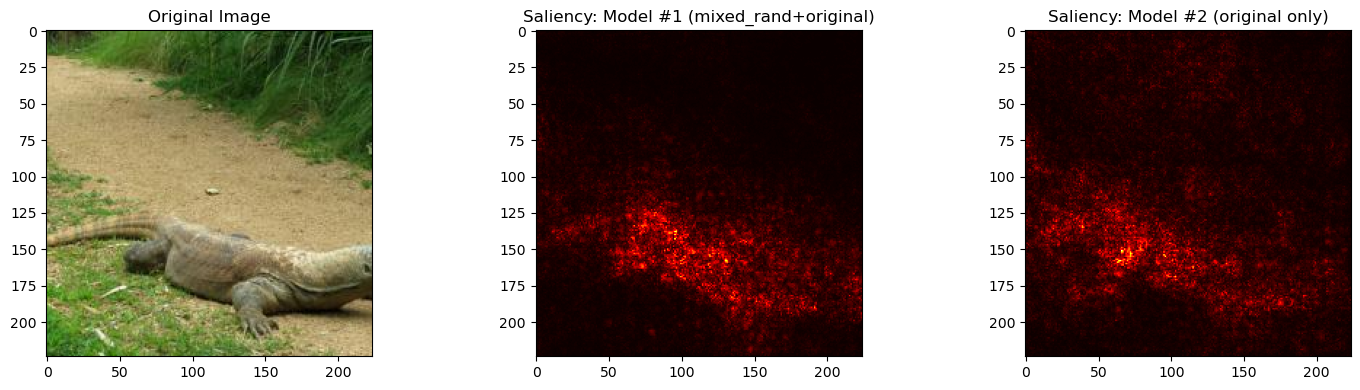

Random image index in dataset: 1027
True label index:              7 (reptile)
Model #1 predicted class idx:  7 (reptile)
Model #2 predicted class idx:  7 (reptile)


In [27]:
import os
import random
import glob
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# --------------------------------------------------
# 1) DEVICE & CLASS MAPPINGS
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mapping from your original code
CLASS_TO_IDX = {
    'bird': 0, 'carnivore': 1, 'dog': 2, 'fish': 3,
    'insect': 4, 'instrument': 5, 'primate': 6,
    'reptile': 7, 'vehicle': 8
}

# (Optional) If you want to map indices back to class names:
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}


# --------------------------------------------------
# 2) DATASET DEFINITION
#    We only pick from 'original/val' or 'mixed_rand/val', etc.
#    (Adjust the base path as needed.)
# --------------------------------------------------
class AttackedDataset(Dataset):
    def __init__(self, root, class_to_idx, transform=None):
        self.samples = []
        self.transform = transform
        valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".JPEG"]

        for class_folder in os.listdir(root):
            class_path = os.path.join(root, class_folder)
            if not os.path.isdir(class_path):
                continue

            # Convert folder name into a recognized class key
            # Example folder might be "n01614925_wheeled vehicle"
            # so we split on the first underscore.
            parts = class_folder.split("_", 1)
            if len(parts) < 2:
                continue

            class_name = parts[1].lower()  # e.g. "wheeled vehicle"
            if class_name == "wheeled vehicle":
                class_name = "vehicle"
            if class_name == "musical instrument":
                class_name = "instrument"

            if class_name not in class_to_idx:
                continue

            label = class_to_idx[class_name]

            # Gather images
            for ext in valid_extensions:
                for img_path in glob.glob(os.path.join(class_path, f"*{ext}")):
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# --------------------------------------------------
# 3) IMAGE TRANSFORMS & DATA LOADING
# --------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

base_path = "/Data/hamza.azzouzi/bg_challenge"
val_path = os.path.join(base_path, "original", "val")  # or "mixed_rand/val", etc.

dataset = AttackedDataset(root=val_path, class_to_idx=CLASS_TO_IDX, transform=transform)

print(f"Dataset size: {len(dataset)} samples")
if len(dataset) == 0:
    raise ValueError("No samples found. Check your 'val_path' or folder structure.")

# Pick one random image
random_idx = random.randint(0, len(dataset) - 1)
image_tensor, true_label = dataset[random_idx]

# We'll keep a CPU copy for plotting
def denormalize(tensor, mean, std):
    # In-place unnormalization
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

original_img_for_plot = image_tensor.clone()
original_img_for_plot = denormalize(
    original_img_for_plot, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
).clamp(0, 1)


# --------------------------------------------------
# 4) HELPER FUNCTION: Compute Prediction & Saliency
# --------------------------------------------------
def compute_saliency(model, image, device):
    """
    Given a model and a single preprocessed 'image' (C,H,W) tensor on CPU,
    - Moves it to device
    - Unsqueezes for batch dimension
    - Does a forward pass
    - Computes saliency (gradient) wrt the predicted class
    Returns:
        saliency_map (H,W) on CPU
        predicted_label_index (int)
    """
    # We want a version with grad
    input_tensor = image.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward
    output = model(input_tensor)
    pred_class_idx = output.argmax(dim=1)  # predicted class index
    # Scalar for the predicted class logit
    score = output[0, pred_class_idx]

    # Backward for saliency
    model.zero_grad()
    score.backward()

    # Grab the gradient wrt input
    grad = input_tensor.grad.data.abs().squeeze(0)   # shape: (3, H, W)
    # max across channels
    saliency, _ = torch.max(grad, dim=0)            # shape: (H, W)
    saliency = saliency.detach().cpu()
    return saliency, pred_class_idx.item()


# --------------------------------------------------
# 5) LOAD BOTH MODELS & EVALUATE ON SAME IMAGE
# --------------------------------------------------

# ---------- MODEL #1: trained on mixed_rand + original -----------
model_mixed = models.resnet50(pretrained=False)
num_ftrs = model_mixed.fc.in_features

# Example MLP head for the first model, or simply a linear if that's what you used
mlp_head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 9)
)
model_mixed.fc = mlp_head

checkpoint_mixed = "models_mlp/resnet50_epoch_20.pth"  # your path
state_dict_mixed = torch.load(checkpoint_mixed, map_location=device)
model_mixed.load_state_dict(state_dict_mixed, strict=False)
model_mixed.to(device)
model_mixed.eval()

# Compute saliency for Model #1
saliency_mixed, pred_idx_mixed = compute_saliency(model_mixed, image_tensor, device)


# ---------- MODEL #2: trained only on original -----------
model_original = models.resnet50(pretrained=False)
num_ftrs2 = model_original.fc.in_features
model_original.fc = nn.Linear(num_ftrs2, 9)

checkpoint_original = "resnet50_trained.pth"
state_dict_original = torch.load(checkpoint_original, map_location=device)
model_original.load_state_dict(state_dict_original, strict=False)
model_original.to(device)
model_original.eval()

# Compute saliency for Model #2
saliency_original, pred_idx_original = compute_saliency(model_original, image_tensor, device)


# --------------------------------------------------
# 6) VISUALIZE RESULTS
# --------------------------------------------------
plt.figure(figsize=(15, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img_for_plot.permute(1, 2, 0).numpy())

# Saliency from Model #1 (mixed_rand+original)
plt.subplot(1, 3, 2)
plt.title("Saliency: Model #1 (mixed_rand+original)")
plt.imshow(saliency_mixed.numpy(), cmap='hot')

# Saliency from Model #2 (original only)
plt.subplot(1, 3, 3)
plt.title("Saliency: Model #2 (original only)")
plt.imshow(saliency_original.numpy(), cmap='hot')

plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7) PRINT PREDICTIONS
# --------------------------------------------------
print(f"Random image index in dataset: {random_idx}")
print(f"True label index:              {true_label} ({IDX_TO_CLASS.get(true_label, '?')})")

print(f"Model #1 predicted class idx:  {pred_idx_mixed} "
      f"({IDX_TO_CLASS.get(pred_idx_mixed, '?')})")
print(f"Model #2 predicted class idx:  {pred_idx_original} "
      f"({IDX_TO_CLASS.get(pred_idx_original, '?')})")
